## 1. Introduction on MEGMA & Dataset

### MEGMA
**MEGMA** is short for metagenomic **M**icrobial **E**mbedding, **G**rouping, and **M**apping **A**lgorithm (MEGMA) , which is a further step development of **AggMap** [(v.1.1.6)](https://pypi.org/project/aggmap/1.1.6/) that specific for metagenomic data learning. **MEGMA** is developed to transform the tabular metagenomic data into spatially-correlated color image-like 2D-representations, named as the 2D-microbiomeprints (3D tensor data in the form of row, column and channel, or feature maps, **Fmaps**). 2D-microbiomeprints are multichannel feature maps (Fmaps) and are the inputs of ConvNet-based AggMapNet models. 

![MEGMA](https://github.com/shenwanxiang/bidd-aggmap/blob/master/paper/MEGMA/cover/f2.png?raw=true)

**MEGMA** is released in the **aggmap** package, in this example, we will show how to employ the **aggmap** package to perform **MEGMA** on the cross-nation datasets of metagenomics.

### Metagenomic cross-nation datasets and tasks

The metagenomic cross-nation data covers 849 gut microbial species from fecal samples of total 575 subjects (Colorectal cancers, CRCs or healthy controls, CTRs) compiled by [Wirbel et al.(Nat. Med. 25, 679-689, 2019)](https://www.nature.com/articles/s41591-019-0406-6). It contains five metagenomic datasets from five separate studies in five nations (**FRA**: France, **AUS**: Australia, **DEU**: Germany, **CHN**: China, and **USA**: America). 
             
<div align="center">
   <span style="font-weight:bold;">Table 1. Metagenomic cross-nation data.</span>
</div>



|Dataset|# Case (CRC)|# Control (CTR)|# Species|Download|
|:----|:----|:----|:----|:----|
|**AUS**|46|63|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/AUS_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/AUS_dfx.csv)|
|**CHN**|74|54|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/CHN_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/CHN_dfx.csv)|
|**DEU**|60|60|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/DEU_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/DEU_dfx.csv)|
|**FRA**|53|61|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/FRA_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/FRA_dfx.csv)|
|**USA**|52|52|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/USA_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/USA_dfx.csv)|


The tasks are to build classfication models to classify CRCS from CTRs, and to identify the important microbial species that contribute to CRCs. Each microbe is a feature point in the classfication model, therefore, we need to calculate the feature importance to get the importance score of the microbes. Since we have five independent datasets that from five countries, we can build the model on one country data and test the model performance on the rest of the countries, we called this a study-to-study transfer (**STST**, model trained on one nation data and tested on the rest nations) experiment. The **STST** can tell us the real performance of the metagenomc machine learning models in the application of the external data. Therefore, in this example, the study-to-study transfer will be used for the evaluation of the performance of the metagenomic prediction models and the consistency of the across-nation biomarker discovery. Note that since **MEGMA** is an unsupervised learning method, we can use all unlabeled metagenomic data to fit `megma` (AKA, to train `megma`). Using all unlabeled data makes it more accurate and robust when calculating pairwise distances between microbes. Because the feature points in a country's metagenomic data may have very low variance, the correlation between microbes cannot be accurately calculated.

## 2. MEGMA Training & Transformation

**MEGMA** is an unsupervised learning method, and it can be trained by the metagnomic abundance data only (without label information), the 2D-microbiomeprints can be transformed by the trained `megma` object from the metagnomic abundance vectors.

Therefore, we can train the `megma` based on all of the metagnomic abundance data (`megma_all`) or metagnomic abundance data of only one country (`megma_country_name`). Fitting the `megma` object with different data can produce different 2D-microbiomeprints. Because different data controls the arrangement and placement of feature points (i.e., the microbes), the correlation distance or similar matrix of the microbes can be different when calculated by different data. 

But in general, the correlation matrix calculated based on the whole data can be more robust and accurately (Because microbe-to-microbe correlation distances/similarities are measured with more samples), and consequently, the 2D-microbiomeprints can be more structured and patterned. In this example, we will show how to generate the 2D-microbiomeprints based on the whole data or one country data, and to see the differences of 2D-microbiomeprints.

In [518]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet
from aggmap import show, loadmap

import os

if not os.path.exists('./images'):
    os.makedirs('./images')

### Fitting MEGMA on metagenomic abundance data of all countries

Now, let's try to use all of the unlabelled metagenomic abundance data to fit **megma**, and then to transform the 2D-microbiomeprints by the pre-fitted **megma**, the **megma** trained on all data is name as `megma_all`.

We can compare the 2D-microbiomeprints generated by the **megma** that fitted by all countries metagenomic abundance data and one country metagenomic abundance data.

#### Read and preprocess data for MEGMA

The metagenomic abundance data is logarithm-transformed, and to avoid the invalid logarithm transformation for zero values, a minimal value (1e-8) is added to all of the data. This operation is necessary because it can make sure that the pairwise correlation distance can be measured accurately.

In [519]:
## dataset url
url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
countries = ['CHN', 'AUS', 'DEU', 'FRA', 'USA']
minv = 1e-8 #minimal value for log-transform

## Concate data of all countries
all_dfx = []
for country in countries:
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
    all_dfx.append(dfx_vector)
dfx_all = pd.concat(all_dfx, axis=0)
dfx_all = np.log(dfx_all + minv)

print('The number of samples to pre-fit: %s, the number of feature points: %s. \n' % dfx_all.shape)

The number of samples to pre-fit: 575, the number of feature points: 849. 



In [520]:
dfx_all[dfx_all.columns[:4]].head(8)

,Clostridium saccharogumia [ref_mOTU_v2_0473],Clostridium innocuum [ref_mOTU_v2_0643],Clostridium sp. KLE 1755 [ref_mOTU_v2_0860],Clostridium scindens [ref_mOTU_v2_0883]
Sample_ID,,,,
ERR1018185,-18.420681,-9.271705,-9.271705,-8.578611
ERR1018186,-18.420681,-8.889649,-7.097950,-8.196538
ERR1018187,-18.420681,-9.300529,-8.607436,-8.607436
ERR1018188,-18.420681,-8.072227,-9.170776,-8.072227
ERR1018189,-18.420681,-18.420681,-18.420681,-18.420681
ERR1018190,-18.420681,-8.601296,-7.502720,-8.601296
ERR1018191,-18.420681,-9.211839,-18.420681,-5.383296
ERR1018192,-18.420681,-5.575946,-8.943168,-18.420681


#### MEGMA initialization, fitting and dump

In the initialization stage, **MEGMA** supports a varity of metric to measure the distances between the microbes. The default `metric` is the correlation distance. Importantly, **MEGMA** also supports to input a pre-difined distance matrix ( the `info_distance` parameter) for of microbes. 


In the fitting stage, **MEGMA** default uses the UMAP (the `emb_method` parameter) method to perform the embedding of the microbes, the parameter `cluster_channels` is for the grouping of the microbes, it uses the hierarchical clustering algrothm to generate the subgroups of the microbes. Importantly, **MEGMA** also supports to input a pre-difined (or customized) microbial subgroup list (i.e., the `feature_group_list` parameter, it can be used to customize the group of the microbes). More information about **Embedding & Grouping** can be see **[here](https://bidd-aggmap.readthedocs.io/en/master/_example_MEGMA/example_05_embedding_grouping.html)**. 


The parameter `var_thr` can be used to filter out some microbes in very low variances, under the low sample size case (the unlabeled data to fit MEGMA), the variances of same feature points can be very low. **Please be noted** that the parameter `var_thr` is a feature selection parameter and is quite important for low-sample size cases. In practical, `var_thr` can be optimized by the performance the model. In general, higher `var_thr` value can help to generate a more structured feature maps, and therefore the model performance can be improved. If the variance of the feature points is very low, the resulting feature maps will be more randomly arranged. This is because the correlation distances between feature points with low variance cannot be measured very accurately. Consequently, the Fmap looks like a random arrangement. However, the threshold `var_thr` that is too high will lead to a decrease in the number of retained features, which may also lead to the deterioration of model performance. Therefore, we recommended that the `var_thr` is a hyperparameters and shold be optimized by the performance the model. the `var_thr` should be at least greater than 0. More information on the hyperparameters is avaliable **[here](https://bidd-aggmap.readthedocs.io/en/latest/_HPs/hps_content.html#The-important-hyperparameters-in-AggMap-feature-restructuring)**. 

The object **megma**  can be dumped in your disk and then loaded next time by `loadmap`. Basically, the **megma** object is same as a trained model, once it is fitted by the unlabelled data, it can be used to transform an 1D vector into 3D tensor, i.e., the multichannel Fmaps.


In [521]:
## parameters in MEGMA
metric = 'correlation' #distance metric
emb_method = 'umap' #embedding method
cluster_channels = 5 #channel number

## Fitting on all of the data
megma_all = AggMap(dfx_all, metric = metric, by_scipy = True,)
megma_all = megma_all.fit(emb_method = emb_method, 
                          cluster_channels = cluster_channels,  
                          feature_group_list = [],
                          var_thr = 0,
                          verbose = 0)
## save megma
megma_all.save('./megma.all')

#delete megma from memory
del megma_all 

2022-08-12 18:16:37,312 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 2123.56it/s]

2022-08-12 18:16:37,769 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:16:38,392 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:16:39,400 - INFO - [bidd-aggmap] - Finished


#### MEGMA loading and 2D-microbiomeprints transformation
Now, we have deleted the `megma_all` in our memory, but we can reload it by `loadmap`.

Once we have fitted our megma, we are able to use it to transform the abundance vectors. In the transformation stage, metagenomic abundance vector data can be scaled by `scale_method`. The `standard` method is for the *z*-score standard scaling, and the `megma_all.batch_transform` method can transform a set of 1D vectors to 3D tensors (-1, w, h, c), while the `megma_all.transform` method is to transform one 1D vector to one 3D tensor (1, w, h, c). 

In [522]:
#reload megma from disk
megma_all = loadmap('./megma.all')
scale_method = 'standard'#scale method

country = 'CHN' # transform the 2D-microbiomeprints for one country

dfx_vector = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
dfx_vector = np.log(dfx_vector + minv)
X_tensor = megma_all.batch_transform(dfx_vector.values, scale_method = scale_method)
X_tensor.shape

100%|###############################################################################| 128/128 [00:00<00:00, 2343.25it/s]


(128, 30, 29, 5)

In [523]:
dfy = pd.read_csv(url + '%s_dfy.csv' % country, index_col='Sample_ID')
idx = dfy.reset_index().groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
idx

Country  Group
CHN      CRC      [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15...
         CTR      [8, 10, 18, 20, 24, 32, 47, 48, 49, 50, 51, 52...
dtype: object

#### MEGMA 2D-microbiomeprints visulization

The trained `megma` object has attributes of `plot_grid`, `plot_scatter`, `plot_tree` for data visulization. The `plot_grid` is to plot a regular grid, and in this grid, each microbe has an optimized postion, its neighbors are abundance-correlated microbes. The `plot_scatter` is to plot the 2D embedding results of the microbes, the `plot_tree` is to plot the clustering tree of the microbes.

In [524]:
megma_all.plot_grid(htmlpath='./images', htmlname = 'megma_all')

2022-08-12 18:16:39,715 - INFO - [bidd-aggmap] - generate file: ./images/megma_all_feature points_849_correlation_umap_mp
2022-08-12 18:16:39,723 - INFO - [bidd-aggmap] - save html file to ./images/megma_all_feature points_849_correlation_umap_mp


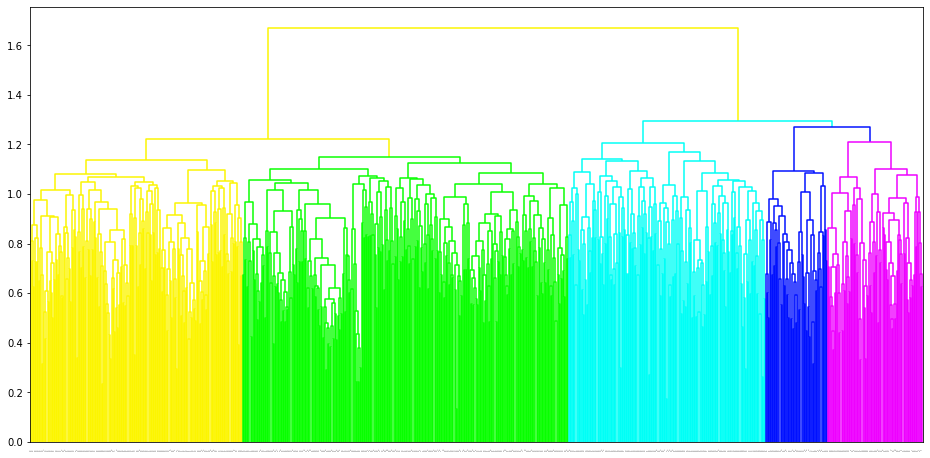

In [525]:
fig = megma_all.plot_tree(add_leaf_labels=False, leaf_font_size = 1)

----
#### Well-trained MEGMA to transform the abundance data of each country

Next, let's to show the transformed feature maps (aka the 2D-microbiomeprints or 3D tensor). the well-trained `megma_all` object is able to transform the data of the rest of countries.

In [526]:
def plot(X, megma, rows, fname = './Country1_fmp.png'):
    n = 5
    fontsize = 40
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(22,9), sharex = True, sharey = True)
    row_names = [', '.join(i) for i in rows]
    for row, row_ax in zip(rows, axes):
        pidx = idx.loc[row][:n]        
        for pid, ax in zip(pidx, row_ax):
            cid = row[0]
            pid_name = '%s-%s' % (cid, pid)
            x = X[pid]
            color_list = pd.Series(megma.colormaps).sort_index().iloc[1:].tolist()
            color_list.append('#000000')
            show.imshow(x, ax = ax,  mode = 'dark', color_list= color_list, x_max=3, vmin=-0.5, vmax=0.9)
            ax.set_title(pid_name, fontsize = fontsize) 
    for ax, row in zip(axes[:,0], row_names):
        ax.set_ylabel(row.split(',')[1], fontsize = fontsize)  

    fig.tight_layout()
    fig.savefig(fname, bbox_inches='tight', dpi=400) 

100%|###############################################################################| 128/128 [00:00<00:00, 2331.83it/s]


Trained MEGMA has transformed 3D tensor for CHN data


100%|###############################################################################| 109/109 [00:00<00:00, 2282.78it/s]


Trained MEGMA has transformed 3D tensor for AUS data


100%|###############################################################################| 120/120 [00:00<00:00, 2187.12it/s]


Trained MEGMA has transformed 3D tensor for DEU data


100%|###############################################################################| 114/114 [00:00<00:00, 2355.19it/s]


Trained MEGMA has transformed 3D tensor for FRA data


100%|###############################################################################| 104/104 [00:00<00:00, 2171.96it/s]


Trained MEGMA has transformed 3D tensor for USA data


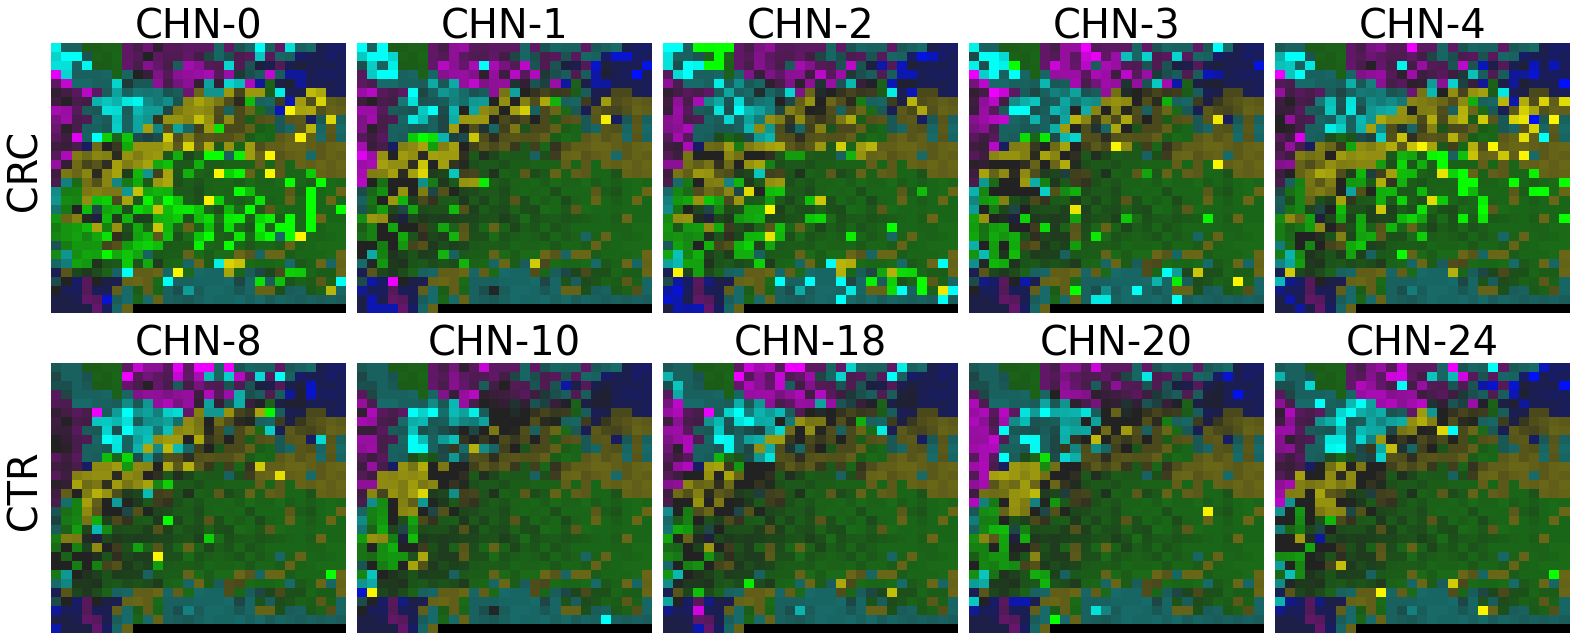

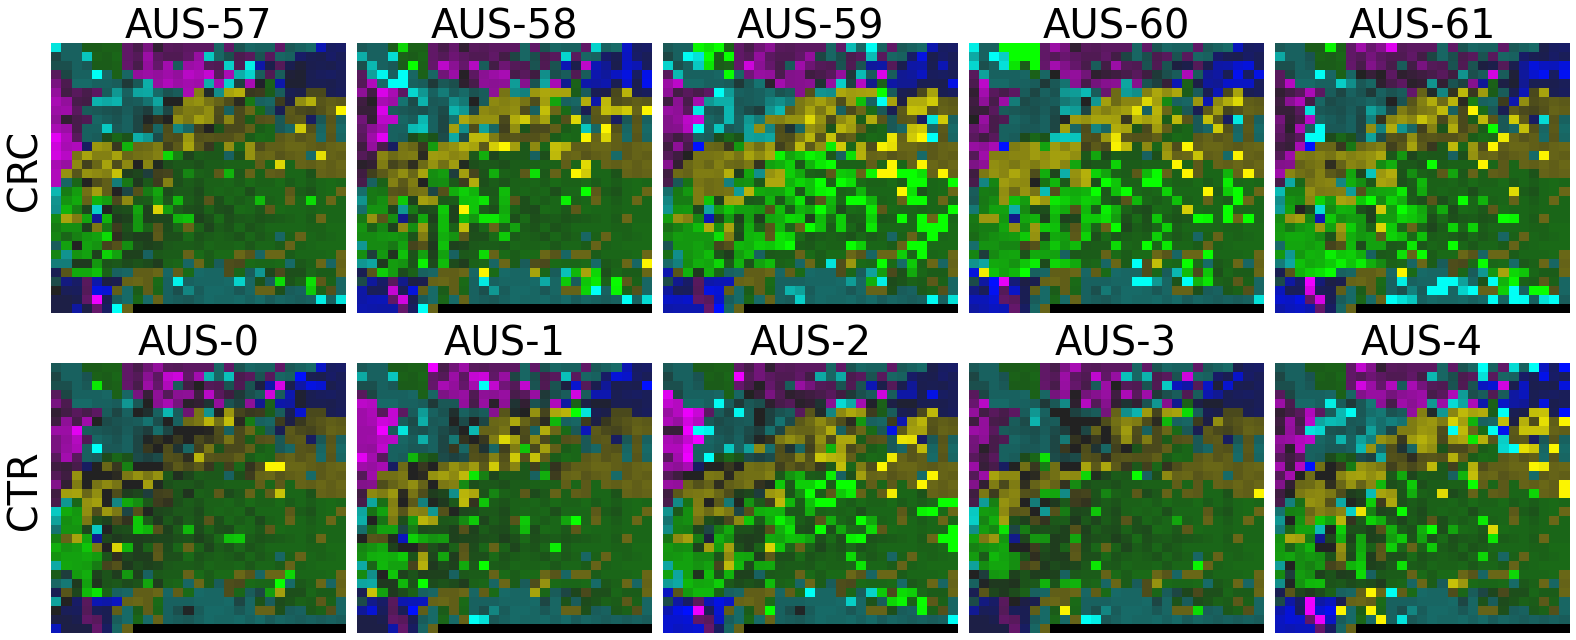

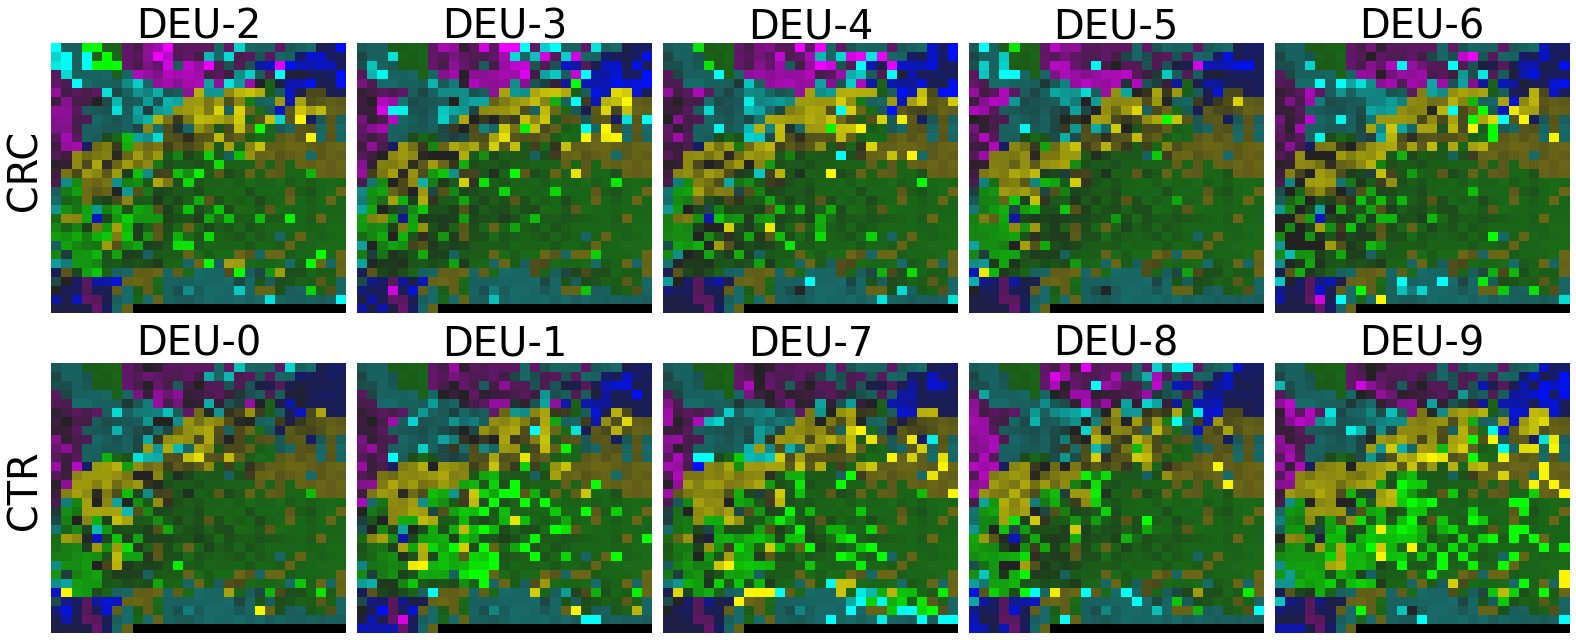

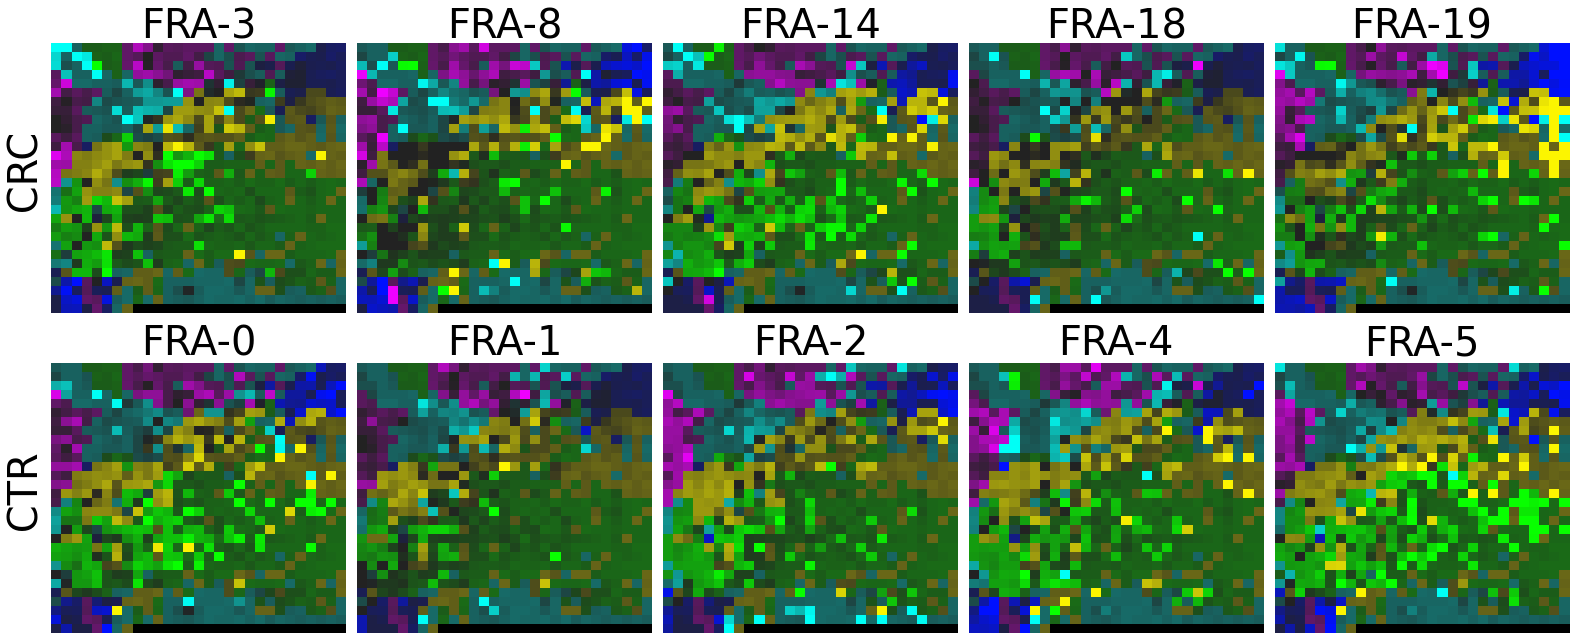

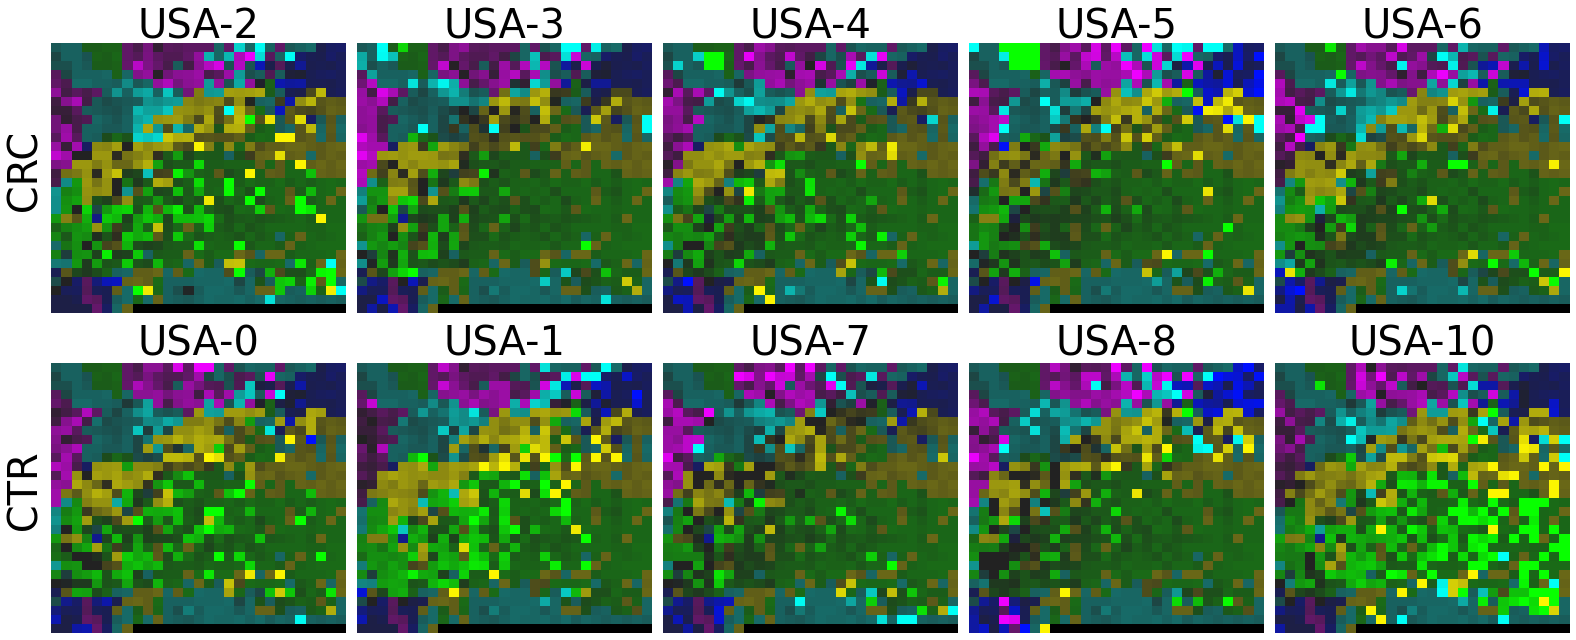

In [527]:
for country in countries:
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    X_tensor = megma_all.batch_transform(dfx_vector.values, scale_method = scale_method)
    print('Trained MEGMA has transformed 3D tensor for %s data' % country)
    
    dfy = pd.read_csv(url + '%s_dfy.csv' % country, index_col='Sample_ID')
    idx = dfy.reset_index().groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
    rows = idx.index.tolist()
    rows = rows[:2]
    
    plot(X_tensor, megma_all, rows, fname = './images/fmp_megma_all_%s.png' % country)

----

### Fitting MEGMA on metagenomic abundance data of one country only

In this section, we will fit the `megma` object on etagenomic abundance data of one country only (such as the CHN data, we will name the fitted megma object as `megma_chn` in this example), later we can transform the data from the rest of the country by the trained country-specific MEGMA. 

#### Read and preprocess data for MEGMA

In [548]:
## dataset
country = 'CHN' # 'USA', 'FRA', 'AUS', 'DEU', 'CHN'
url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
dfx = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
dfy = pd.read_csv(url + '%s_dfy.csv' % country, index_col='Sample_ID')
dfx = np.log(dfx + minv)

#### MEGMA initialization & fitting

`var_thr`, `random_state`, `n_neighbors`, `n_epochs`

The parameter `var_thr` can be used to filter out some microbes in very low variances, under the low sample size case (the unlabeled data to fit MEGMA), the variances of same feature points can be very low. **Please be noted** that the parameter `var_thr` is a feature selection parameter and is quite important for low-sample size cases. In practical, `var_thr` can be optimized by the performance the model. In general, higher `var_thr` value can help to generate a more structured feature maps, and therefore the model performance can be improved. If the variance of the feature points is very low, the resulting feature maps will be more randomly arranged. This is because the correlation distances between feature points with low variance cannot be measured very accurately. Consequently, the Fmap looks like a random arrangement. However, the threshold `var_thr` that is too high will lead to a decrease in the number of retained features, which may also lead to the deterioration of model performance. Therefore, we recommended that the `var_thr` is a hyperparameters and shold be optimized by the performance the model. the `var_thr` should be at least greater than 0. More information on the hyperparameters is avaliable **[here](https://bidd-aggmap.readthedocs.io/en/latest/_HPs/hps_content.html#The-important-hyperparameters-in-AggMap-feature-restructuring)**. 


In [549]:
megma_chn = AggMap(dfx, metric = metric, by_scipy=True, info_distance = None)
megma_chn = megma_chn.fit(emb_method=emb_method, 
                          cluster_channels = cluster_channels, 
                          var_thr = 3.0,  #can be optimized by each megma based on their model performance, such as 1, 2, 4, 8, 10, ..
                          verbose = 0)

2022-08-12 18:30:14,371 - INFO - [bidd-aggmap] - Calculating distance ...


100%|###############################################################################| 849/849 [00:00<00:00, 5696.94it/s]

2022-08-12 18:30:14,551 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-08-12 18:30:15,001 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-12 18:30:15,319 - INFO - [bidd-aggmap] - Finished


#### MEGMA 2D-microbiomeprints transformation

In [550]:
X = megma_chn.batch_transform(dfx.values, scale_method = scale_method)
X.shape

100%|###############################################################################| 128/128 [00:00<00:00, 1849.21it/s]


(128, 26, 25, 5)

#### MEGMA Fmaps visulization

In [551]:
megma_chn.plot_grid(htmlpath='./images', htmlname = 'megma_%s' % country)

2022-08-12 18:30:15,970 - INFO - [bidd-aggmap] - generate file: ./images/megma_CHN_feature points_626_correlation_umap_mp
2022-08-12 18:30:15,983 - INFO - [bidd-aggmap] - save html file to ./images/megma_CHN_feature points_626_correlation_umap_mp


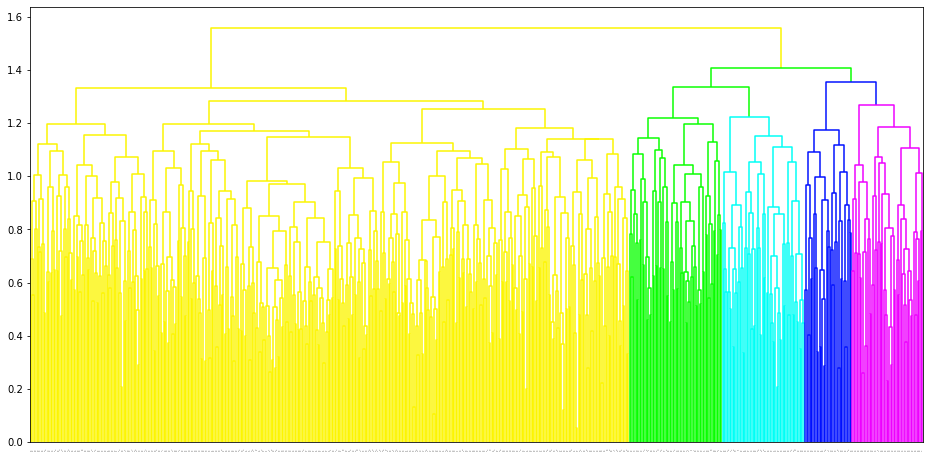

In [552]:
fig = megma_chn.plot_tree(add_leaf_labels = False, leaf_font_size = 1)

In [553]:
idx = dfy.reset_index().groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
idx

Country  Group
CHN      CRC      [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15...
         CTR      [8, 10, 18, 20, 24, 32, 47, 48, 49, 50, 51, 52...
dtype: object

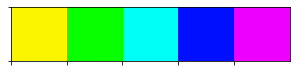

In [555]:
sns.palplot(megma_chn.group_color_dict.values())

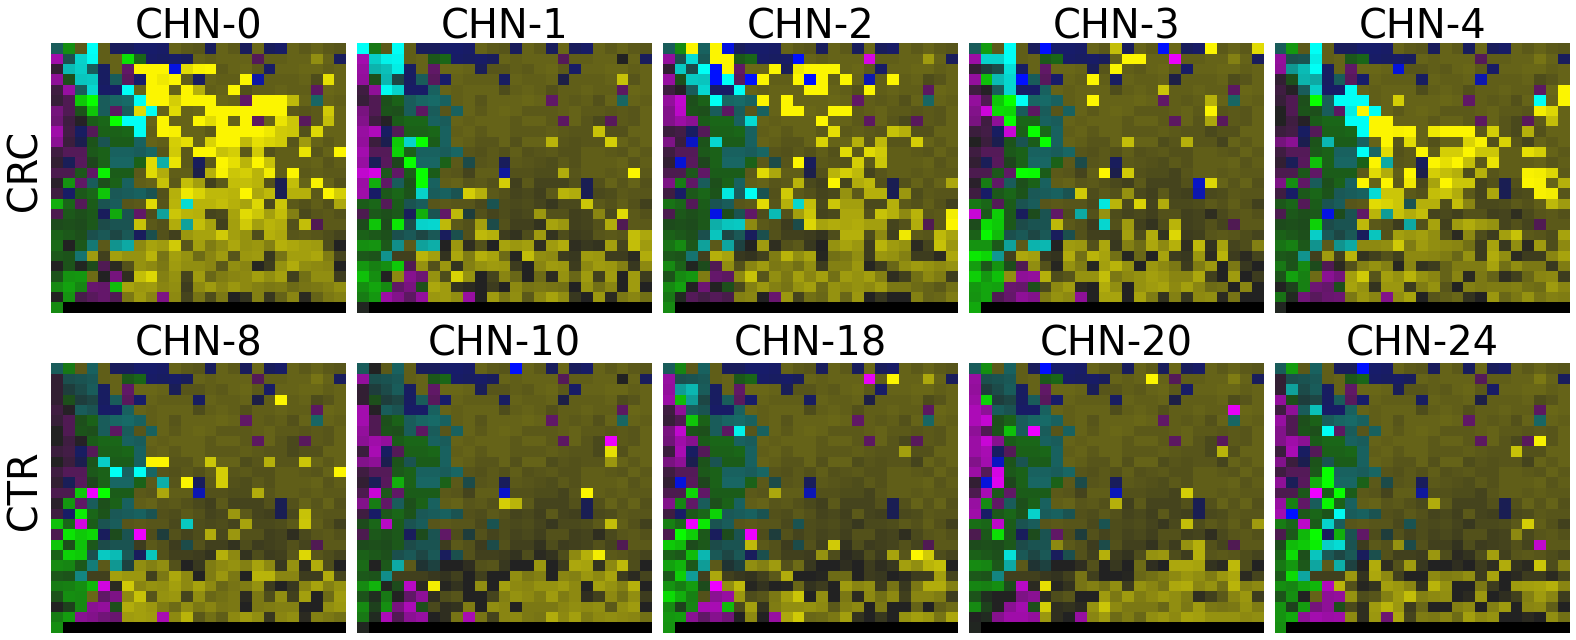

In [556]:
rows = idx.index.tolist()
rows = rows[:2]
plot(X, megma_chn, rows, fname = './images/fmp_%s.png' % country)

#### Well-trained MEGMA to transform the abandance data of the rest countries

We have trained the MEGMA based on one country data, of course it now can transform the metagenomic vector data of this country, but it can also be used to transform the metagenomic vector data of the rest of the countries.

100%|###############################################################################| 128/128 [00:00<00:00, 2196.46it/s]


Trained MEGMA has transformed 3D tensor for CHN data


100%|###############################################################################| 109/109 [00:00<00:00, 3127.19it/s]


Trained MEGMA has transformed 3D tensor for AUS data


100%|###############################################################################| 120/120 [00:00<00:00, 2511.81it/s]


Trained MEGMA has transformed 3D tensor for DEU data


100%|###############################################################################| 114/114 [00:00<00:00, 2381.22it/s]


Trained MEGMA has transformed 3D tensor for FRA data


100%|###############################################################################| 104/104 [00:00<00:00, 2471.88it/s]


Trained MEGMA has transformed 3D tensor for USA data


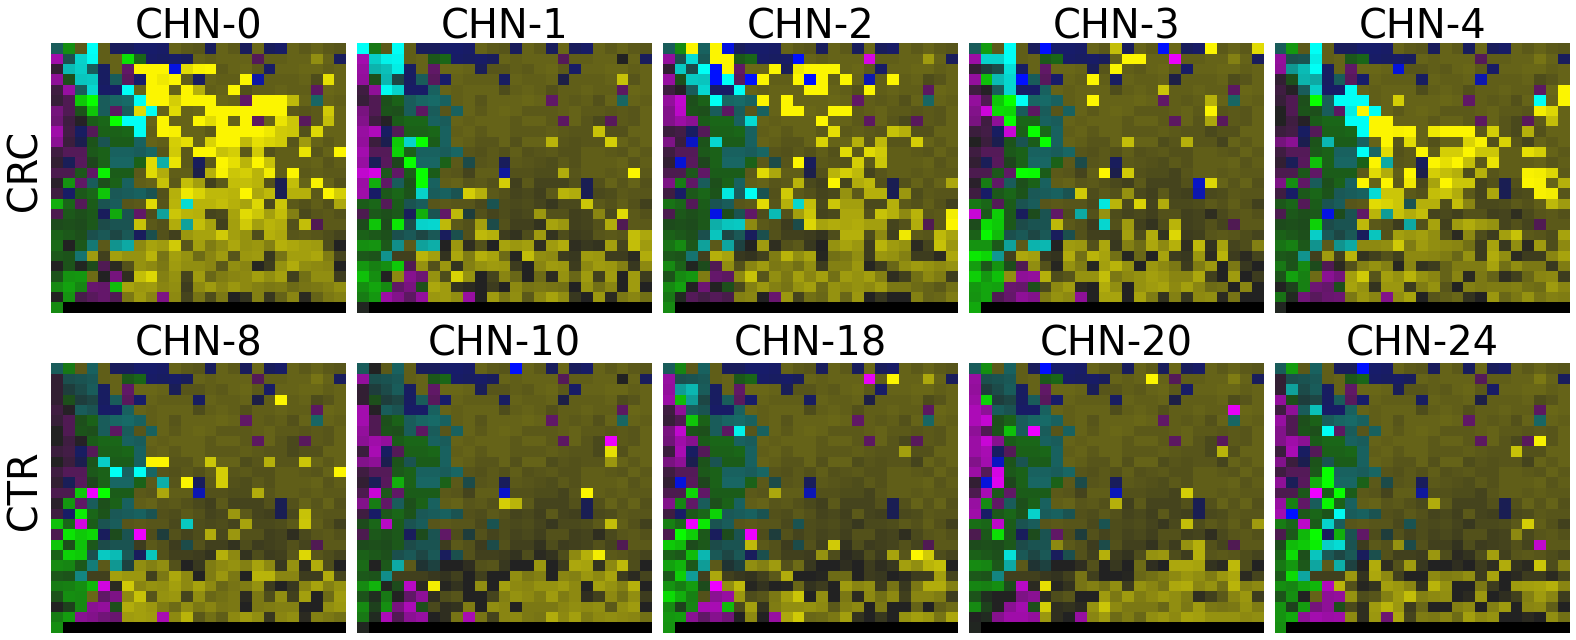

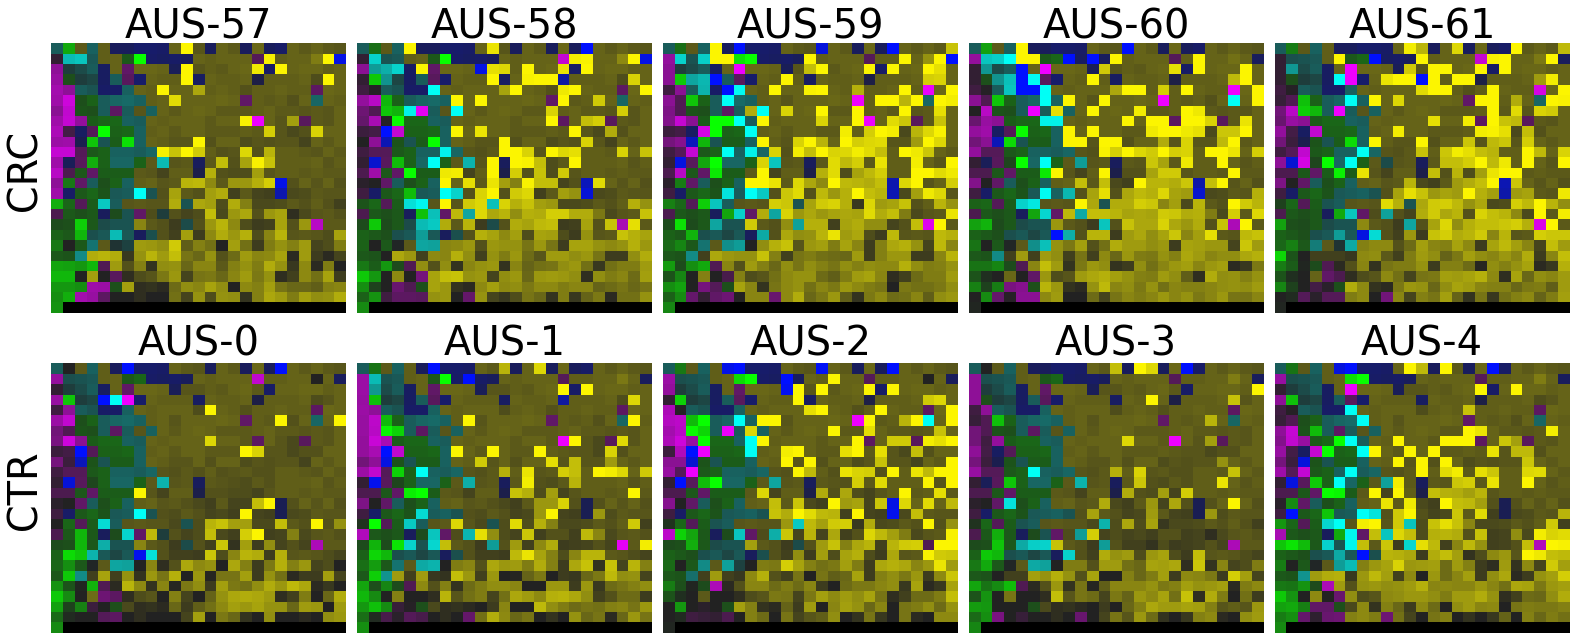

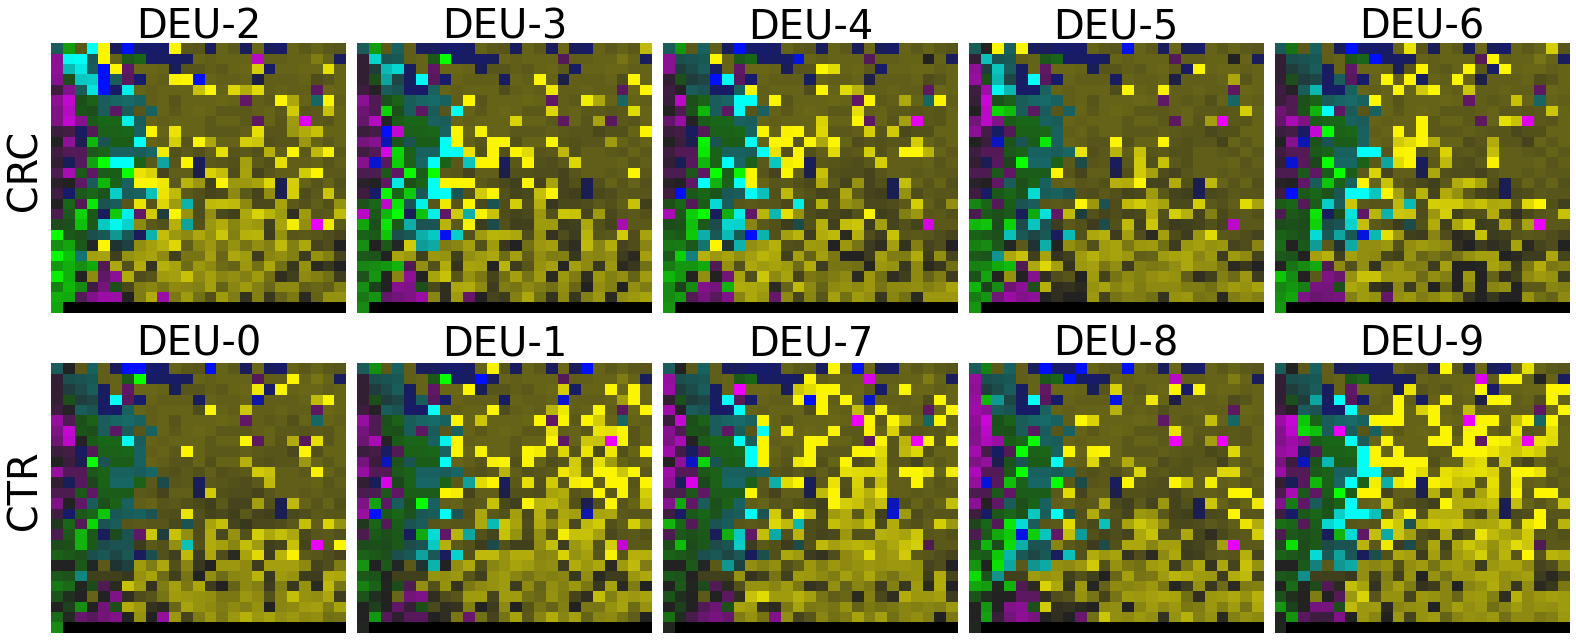

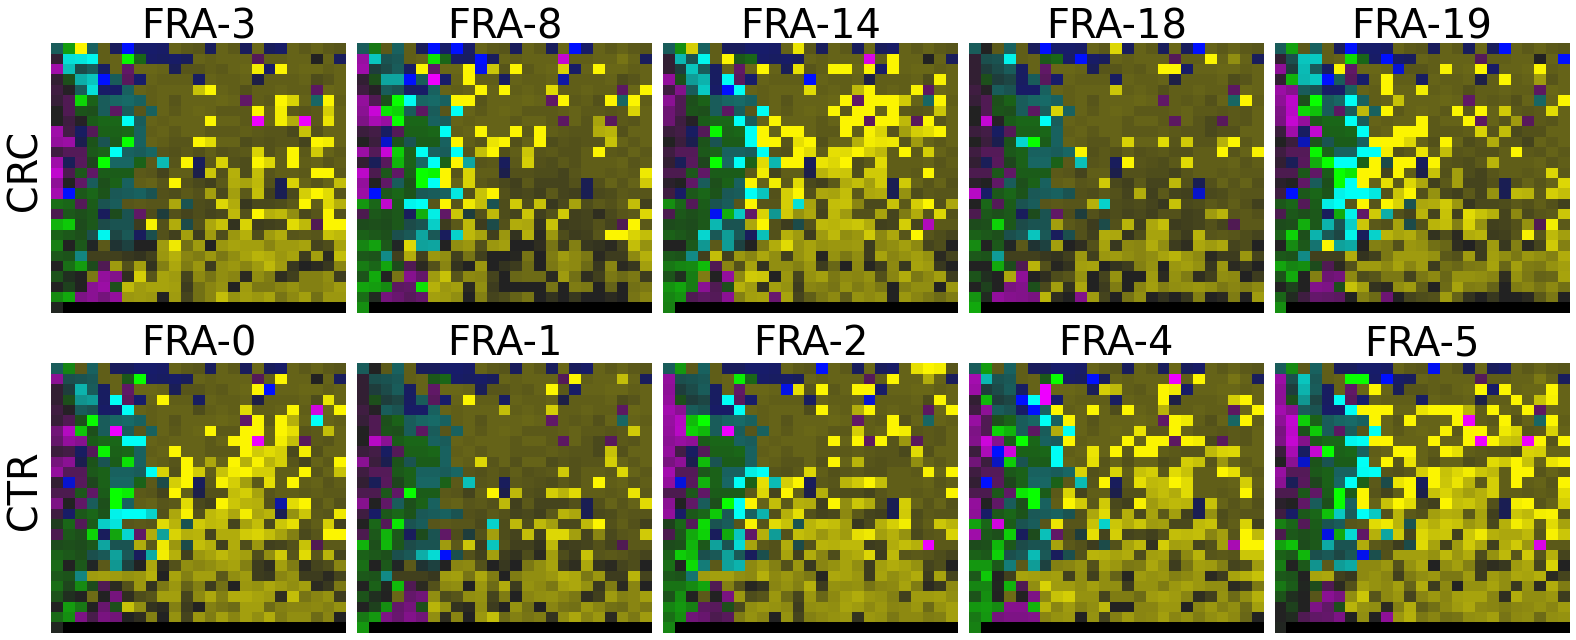

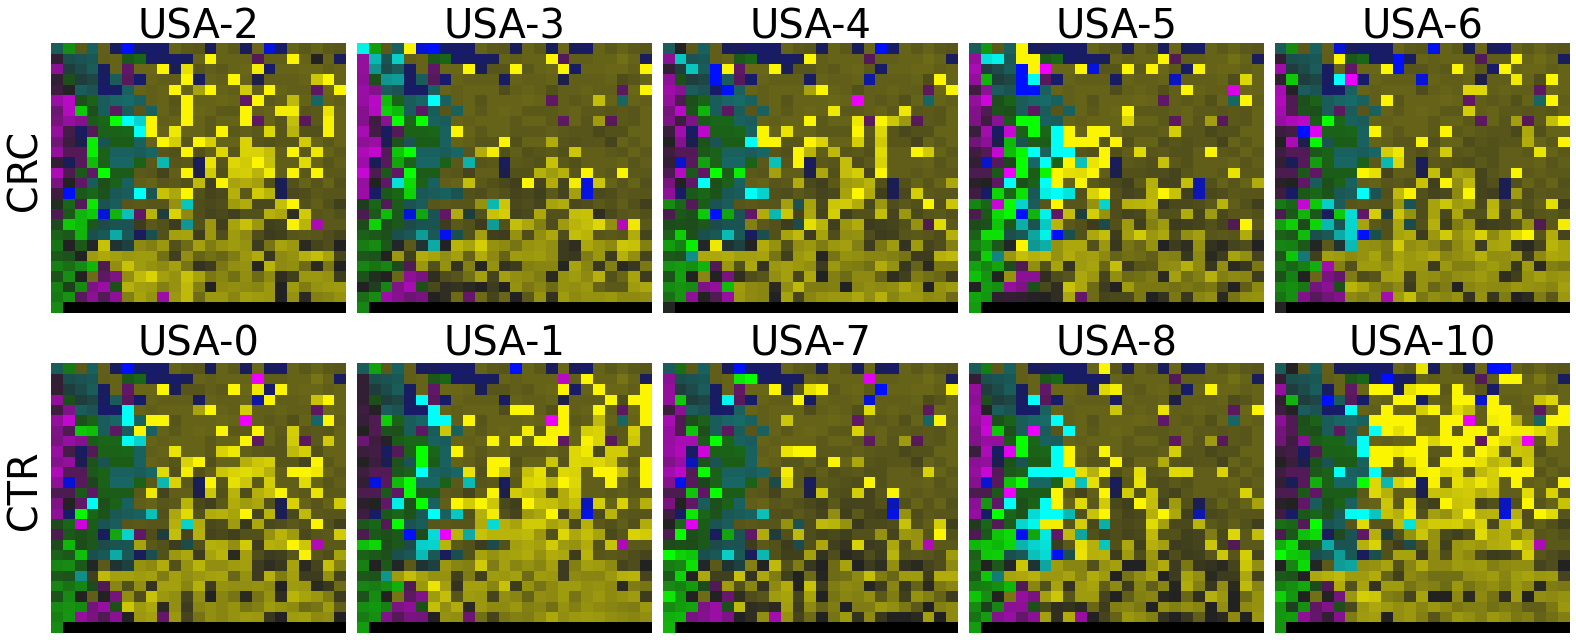

In [557]:
for country in countries:
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    X_tensor = megma_chn.batch_transform(dfx_vector.values, scale_method = scale_method)
 
    print('Trained MEGMA has transformed 3D tensor for %s data' % country)
    
    dfy = pd.read_csv(url + '%s_dfy.csv' % country, index_col='Sample_ID')
    idx = dfy.reset_index().groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
    rows = idx.index.tolist()
    rows = rows[:2]
    
    plot(X_tensor, megma_chn, rows, fname = './images/fmp_%s.png' % country)

#### Fitting country-specific megma for all countries

----
### Discussions & conclusions on MEGMA 2D-microbiomeprints

Now, let's use our naked eyes (label the important zone manually) to find the distinct area for the CRCs and CTRs in the generated **2D-microbiomeprints** by the `megma_chn` and `megma_all` objects, respectively. We can indentify the important zone of `megma_chn` generated **2D-microbiomeprints** easily, it is located in the lower left yellow area of the feature maps (**Fig.1**). However, the important zone for `megma_all` generated **2D-microbiomeprints** is different, which is located in the top left corner of the feature maps (**Fig.2**).

This is because when different datasets are used to fit megma, the final arrangement of microorganisms is different due to the inconsistent correlation distance between microorganisms determined by the datasets. Nonetheless, important microbes always cluster together to form hotspots. In subsequent analyses, we will identify these important microorganisms based on interpretable deep learning methods, to find out whether the microorganisms in different hot zones generated by the two methods are consistent or not.


Except for that, we can draw anther important conlusion, that is, the feature maps generated by `megma_chn` for **CHN** data is much more ordered and structured than the data in the rest of the countries, this is because the `megma_chn` is only trained on the **CHN** data. On the feature maps generated by `megma_all`, we can see that the feature maps of all countries are quite ordered and structured. Therefore, in practical usage, we'd like to recommend to fit on larger samples, because the intrinsic relationship between feature points can be better exposed by higher-sample data. Unsupervised `megma` operates in separate fitting and transformation stages for enabling transfer learning. The fitting operation can be trained on higher-sample unlabeled data and subsequently used for transforming low-sample unlabeled data. `megma` can also be dumped into local disk and reloaded next time for re-fitting or transformation.


![tr_ts1](./images/tr_CHN_ts_All.png)

**Fig.1** the `megma_chn` generated **2D-microbiomeprints** for the five countries, the important zone identified by naked eye  (distinct zone of CRCs from healthy controls) is highlight by the red box.

![tr_ts2](./images/tr_All_ts_All.png)

**Fig.2** the `megma_all` generated **2D-microbiomeprints** for the five countries, the important zone identified by naked eye  (distinct zone of CRCs from healthy controls) is highlight by the red box.